# Characterizing errors in direct-$R_{zx}$ gates

- Calibrate the width-to-phi conversion by a Rabi fit
  - Allow for a offset $\phi_0$ because width 0 can still effect a rotation in the cancelling scheme
- Identify the width corresponding to $\phi = 0.1$ rotation, repeat the gate 10 times and compare the result with $R_{zx}(1)$

Result: Cancelling scheme has a really bad error accumulation (30%). Pulse-efficient scheme ends up with about 10% error.
Note: The implementation of the cancelling gate here lets the flank of the CR pulse run longer than the cancelling pulse. Can e.g. adjusting the sigma parameter mitigate the error?

In [1]:
import re
import numpy as np
import scipy
from qiskit import IBMQ, QuantumCircuit, QuantumRegister, pulse, transpile
from qiskit.circuit import Gate

from pulse_experiment_utils import *

In [2]:
def pulse_efficient_cr_core_schedule(phi_value, cx_schedule, backend):
    instructions = cx_schedule.instructions

    control_qubit_drive = instructions[0][1].channel # ShiftPhase
    control_qubit = control_qubit_drive.index
    target_qubit_drive = instructions[5][1].channel # Drag
    target_qubit = target_qubit_drive.index
    control_drive = next(inst[1].channel for inst in instructions if (type(inst[1]) is pulse.Play and type(inst[1].channel) is pulse.ControlChannel))
    
    x_pulse = get_instruction_by_name(cx_schedule, r'Xp_d[0-9]+$').pulse
    cx_cr_pulse = get_instruction_by_name(cx_schedule, r'CR90p_u[0-9]+$').pulse
    cx_rotary_pulse = get_instruction_by_name(cx_schedule, r'CR90p_d[0-9]+_u[0-9]+$').pulse    

    if phi_value == 0.:
        with pulse.build(backend=backend, default_alignment='sequential', name='cr_gate_core') as cr_core_sched:
            pulse.play(x_pulse, control_qubit_drive)
            
        return cr_core_sched

    cr_amp = cx_cr_pulse.amp
    crr_amp = cx_rotary_pulse.amp
    sigma = cx_cr_pulse.sigma
    flank_width = (cx_cr_pulse.duration - cx_cr_pulse.width) // 2

    normal_flank_integral = np.sqrt(np.pi / 2.) * sigma * scipy.special.erf(flank_width / np.sqrt(2.) / sigma)
    pedestal = np.exp(-0.5 * np.square(flank_width / sigma))
    grounded_flank_integral = (normal_flank_integral - pedestal * flank_width) / (1. - pedestal)
    flank_area = np.abs(cr_amp) * grounded_flank_integral
    cr45_area_norm = np.abs(cr_amp) * cx_cr_pulse.width + 2. * flank_area
    minimum_phi = 2. * np.pi / 4. * (2. * flank_area) / cr45_area_norm

    phi_label = np.round(phi_value / np.pi * 180.)
    if phi_value <= minimum_phi:
        amp_ratio = phi_value / minimum_phi
        duration = 2 * flank_width
        cr_pulse = pulse.Gaussian(duration=duration, amp=(amp_ratio * cr_amp), sigma=sigma, name='CR{}p_u{}'.format(phi_label, control_drive.index))
        cr_rotary_pulse = pulse.Gaussian(duration=duration, amp=(amp_ratio * crr_amp), sigma=sigma, name='CR{}p_d{}_u{}'.format(phi_label, target_qubit, control_drive.index))
        cr_echo = pulse.Gaussian(duration=duration, amp=-(amp_ratio * cr_amp), sigma=sigma, name='CR{}m_u{}'.format(phi_label, control_drive.index))
        cr_rotary_echo = pulse.Gaussian(duration=duration, amp=-(amp_ratio * crr_amp), sigma=sigma, name='CR{}m_d{}_u{}'.format(phi_label, target_qubit, control_drive.index))
    else:
        area = phi_value / 2. / (np.pi / 4.) * cr45_area_norm
        width = (area - 2. * flank_area) / np.abs(cr_amp)
        duration = get_closest_multiple_of_16(width + 2 * flank_width)
        cr_pulse = pulse.GaussianSquare(duration=duration, amp=cr_amp, sigma=sigma, width=width, name='CR{}p_u{}'.format(phi_label, control_drive.index))
        cr_rotary_pulse = pulse.GaussianSquare(duration=duration, amp=crr_amp, sigma=sigma, width=width, name='CR{}p_d{}_u{}'.format(phi_label, target_qubit, control_drive.index))
        cr_echo = pulse.GaussianSquare(duration=duration, amp=-cr_amp, sigma=sigma, width=width, name='CR{}m_u{}'.format(phi_label, control_drive.index))
        cr_rotary_echo = pulse.GaussianSquare(duration=duration, amp=-crr_amp, sigma=sigma, width=width, name='CR{}m_d{}_u{}'.format(phi_label, target_qubit, control_drive.index))
    
    with pulse.build(backend=backend, default_alignment='sequential', name='cr_gate_core') as cr_core_sched:
        ## echo (without the first X on control)
        with pulse.align_left():
            pulse.play(cr_echo, control_drive, name=cr_echo.name)
            pulse.play(cr_rotary_echo, target_qubit_drive, name=cr_rotary_echo.name)

        pulse.play(x_pulse, control_qubit_drive, name=x_pulse.name)

        ## forward
        with pulse.align_left():
            pulse.play(cr_pulse, control_drive, name=cr_pulse.name)
            pulse.play(cr_rotary_pulse, target_qubit_drive, name=cr_rotary_pulse.name)
            
    return cr_core_sched

In [3]:
def pulse_efficient_rzx(phi_value, cx_schedule, backend, with_schedule=False):
    register = QuantumRegister(2)
    
    if phi_value == 0.:
        circuit = QuantumCircuit(register)

        if with_schedule:
            return circuit, pulse.Schedule(name='cr_gate_core')
        else:
            return circuit

    instructions = cx_schedule.instructions    

    control_qubit_drive = next(inst.channel for _, inst in instructions if (type(inst) is pulse.ShiftPhase and type(inst.channel) is pulse.DriveChannel))
    control_qubit = control_qubit_drive.index
    target_qubit_drive = get_instruction_by_name(cx_schedule, r'X90p_d[0-9]+$').channel # Drag
    target_qubit = target_qubit_drive.index
    
    cx_cr_pulse = get_instruction_by_name(cx_schedule, r'CR90p_u[0-9]+$').pulse
    
    cr_core_sched = pulse_efficient_cr_core_schedule(phi_value, cx_schedule, backend)
            
    cr_core_gate = Gate('cr_core_gate', 2, [])
    
    circuit = QuantumCircuit(register)
    circuit.x(0)
    circuit.append(cr_core_gate, (0, 1))

    circuit.add_calibration('cr_core_gate', (control_qubit, target_qubit), cr_core_sched)
    
    if with_schedule:
        return circuit, cr_core_sched
    else:
        return circuit    

In [4]:
def linearized_cr_core_schedule(width, cx_schedule, backend, phi_label=0):
    instructions = cx_schedule.instructions

    control_qubit_drive = next(inst.channel for _, inst in instructions if (type(inst) is pulse.ShiftPhase and type(inst.channel) is pulse.DriveChannel))
    control_qubit = control_qubit_drive.index
    target_qubit_drive = get_instruction_by_name(cx_schedule, r'X90p_d[0-9]+$').channel # Drag
    target_qubit = target_qubit_drive.index
    control_drive = next(inst.channel for _, inst in instructions if (type(inst) is pulse.Play and type(inst.channel) is pulse.ControlChannel))
    
    x_pulse = get_instruction_by_name(cx_schedule, r'Xp_d[0-9]+$').pulse
    cx_cr_pulse = get_instruction_by_name(cx_schedule, r'CR90p_u[0-9]+$').pulse
    cx_rotary_pulse = get_instruction_by_name(cx_schedule, r'CR90p_d[0-9]+_u[0-9]+$').pulse
    
    if width == 0.:
        with pulse.build(backend=backend, default_alignment='sequential', name='cr_gate_core') as cr_core_sched:
            pulse.play(x_pulse, control_qubit_drive)
            
        return cr_core_sched
    
    cr_amp = cx_cr_pulse.amp
    crr_amp = cx_rotary_pulse.amp
    sigma = cx_cr_pulse.sigma
    flank_width = (cx_cr_pulse.duration - cx_cr_pulse.width) // 2
    
    if width > 0.:
        duration = int(np.ceil((width + 2 * flank_width) / 16.) * 16)
        cr_pulse = pulse.GaussianSquare(duration=duration, amp=cr_amp, sigma=sigma, width=width, name='CR{}p_u{}'.format(phi_label, control_drive.index))
        cr_rotary_pulse = pulse.GaussianSquare(duration=duration, amp=crr_amp, sigma=sigma, width=width, name='CR{}p_d{}_u{}'.format(phi_label, target_qubit, control_drive.index))
        cr_echo = pulse.GaussianSquare(duration=duration, amp=-cr_amp, sigma=sigma, width=width, name='CR{}m_u{}'.format(phi_label, control_drive.index))
        cr_rotary_echo = pulse.GaussianSquare(duration=duration, amp=-crr_amp, sigma=sigma, width=width, name='CR{}m_d{}_u{}'.format(phi_label, target_qubit, control_drive.index))
        
        duration = 2 * flank_width
        cancel_pulse = pulse.Gaussian(duration=duration, amp=-cr_amp, sigma=sigma, name='ACR{}p_u{}'.format(phi_label, control_drive.index))
        cancel_rotary_pulse = pulse.Gaussian(duration=duration, amp=-crr_amp, sigma=sigma, name='ACR{}p_d{}_u{}'.format(phi_label, target_qubit, control_drive.index))
        cancel_echo = pulse.Gaussian(duration=duration, amp=cr_amp, sigma=sigma, name='ACR{}m_u{}'.format(phi_label, control_drive.index))
        cancel_rotary_echo = pulse.Gaussian(duration=duration, amp=crr_amp, sigma=sigma, name='ACR{}m_d{}_u{}'.format(phi_label, target_qubit, control_drive.index))
        
    else:
        duration = 2 * flank_width
        cr_pulse = pulse.Gaussian(duration=duration, amp=cr_amp, sigma=sigma, name='CR{}p_u{}'.format(phi_label, control_drive.index))
        cr_rotary_pulse = pulse.Gaussian(duration=duration, amp=crr_amp, sigma=sigma, name='CR{}p_d{}_u{}'.format(phi_label, target_qubit, control_drive.index))
        cr_echo = pulse.Gaussian(duration=duration, amp=-cr_amp, sigma=sigma, name='CR{}m_u{}'.format(phi_label, control_drive.index))
        cr_rotary_echo = pulse.Gaussian(duration=duration, amp=-crr_amp, sigma=sigma, name='CR{}m_d{}_u{}'.format(phi_label, target_qubit, control_drive.index))
        
        duration = int(np.ceil((-width + 2 * flank_width) / 16.) * 16)
        cancel_pulse = pulse.GaussianSquare(duration=duration, amp=-cr_amp, sigma=sigma, width=-width, name='ACR{}p_u{}'.format(phi_label, control_drive.index))
        cancel_rotary_pulse = pulse.GaussianSquare(duration=duration, amp=-crr_amp, sigma=sigma, width=-width, name='ACR{}p_d{}_u{}'.format(phi_label, target_qubit, control_drive.index))
        cancel_echo = pulse.GaussianSquare(duration=duration, amp=cr_amp, sigma=sigma, width=-width, name='ACR{}m_u{}'.format(phi_label, control_drive.index))
        cancel_rotary_echo = pulse.GaussianSquare(duration=duration, amp=crr_amp, sigma=sigma, width=-width, name='ACR{}m_d{}_u{}'.format(phi_label, target_qubit, control_drive.index))

    with pulse.build(backend=backend, default_alignment='sequential', name='cr_gate_core') as cr_core_sched:
        ## echo (without the first X on control)
        with pulse.align_left():
            pulse.play(cr_echo, control_drive)
            pulse.play(cancel_echo, control_drive)
            pulse.play(cr_rotary_echo, target_qubit_drive)
            pulse.play(cancel_rotary_echo, target_qubit_drive)

        pulse.play(x_pulse, control_qubit_drive)

        ## forward
        with pulse.align_left():
            pulse.play(cr_pulse, control_drive)
            pulse.play(cancel_pulse, control_drive)
            pulse.play(cr_rotary_pulse, target_qubit_drive)
            pulse.play(cancel_rotary_pulse, target_qubit_drive)
            
    return cr_core_sched

In [5]:
def linearized_rzx(phi_value, cx_schedule, phi_at_cx_width, backend, with_schedule=False, correction_params=None):
    register = QuantumRegister(2)
    
    if phi_value == 0.:
        circuit = QuantumCircuit(register)

        if with_schedule:
            return circuit, pulse.Schedule(name='cr_gate_core')
        else:
            return circuit

    instructions = cx_schedule.instructions

    control_qubit_drive = instructions[0][1].channel # ShiftPhase
    control_qubit = control_qubit_drive.index
    target_qubit_drive = instructions[5][1].channel # Drag
    target_qubit = target_qubit_drive.index
    
    cx_cr_pulse = get_instruction_by_name(cx_schedule, r'CR90p_u[0-9]+$').pulse
    
    phi_to_width = cx_cr_pulse.width / phi_at_cx_width 

    width = phi_value * phi_to_width

    if correction_params is not None:
        width -= (correction_params[0] * phi_value + correction_params[1]) * phi_to_width
        
    cr_core_sched = linearized_cr_core_schedule(width, cx_schedule, backend, phi_label=int(np.round(phi_value / np.pi * 180.)))
            
    cr_core_gate = Gate('cr_core_gate', 2, [])
    
    circuit = QuantumCircuit(register)
    circuit.x(0)
    circuit.append(cr_core_gate, (0, 1))

    circuit.add_calibration('cr_core_gate', (control_qubit, target_qubit), cr_core_sched)
    
    if with_schedule:
        return circuit, cr_core_sched
    else:
        return circuit

In [6]:
#from qiskit_private_tools import backends_table, my_backends

#backends_table()
#backend = my_backends['ibm_kawasaki']

In [7]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo', group='internal', project='icepp')
backend = provider.get_backend('ibm_kawasaki')

In [8]:
control_qubit = 12
target_qubit = 13

backend_config = backend.configuration()
backend_defaults = backend.defaults()
calibrations = backend_defaults.instruction_schedule_map
cx_schedule = calibrations.get('cx', [control_qubit, target_qubit])

## Initial calibration

In [9]:
import pprint
pprint.pprint(cx_schedule.instructions)

((0, ShiftPhase(1.5707963267948966, DriveChannel(12))),
 (0, ShiftPhase(1.5707963267948966, ControlChannel(21))),
 (0, ShiftPhase(1.5707963267948966, ControlChannel(27))),
 (0, ShiftPhase(1.5707963267948966, ControlChannel(32))),
 (0,
  Play(Drag(duration=160, amp=(-3.5219533484902005e-17-0.19172621041660456j), sigma=40, beta=0.2924140638154531, name='Ym_d12'), DriveChannel(12), name='Ym_d12')),
 (0,
  Play(Drag(duration=160, amp=(0.08974290638732331+0.0017556567031520968j), sigma=40, beta=-1.1910275152487093, name='X90p_d13'), DriveChannel(13), name='X90p_d13')),
 (160,
  Play(GaussianSquare(duration=752, amp=(0.040256367422137306+0.0014073244137279123j), sigma=64, width=496, name='CR90p_d13_u25'), DriveChannel(13), name='CR90p_d13_u25')),
 (160,
  Play(GaussianSquare(duration=752, amp=(-0.07411418145274588+0.1632052228883244j), sigma=64, width=496, name='CR90p_u25'), ControlChannel(25), name='CR90p_u25')),
 (912,
  Play(Drag(duration=160, amp=(0.19172621041660456+0j), sigma=40, beta=

In [10]:
do_initial_calibration = False

cx_cr_pulse = get_instruction_by_name(cx_schedule, r'CR90p_u[0-9]+$').pulse
phi_at_cx_width = cx_cr_pulse.width # -> phi to width conversion factor = 1

if do_initial_calibration:
    circuits = []
    for width in range(0, 2 * cx_cr_pulse.width + 1, 32):
        circuit = linearized_rzx(width, cx_schedule, phi_at_cx_width, backend)
        circuit.measure_all()
        circuits.append(circuit)

    circuits = transpile(circuits, backend=backend, initial_layout=[control_qubit, target_qubit])

    job = backend.run(circuits, shots=8192)
    print(job.job_id())

    job_monitor(job)

    result = job.result()
    print(result.get_counts())

    x_values = np.arange(0, 2 * cx_cr_pulse.width + 1, 32)
    y_values = plot_counts(result, ['00', '01'], x=x_values)

    init_params = [np.pi / 900., 0., 0.5, 0.5]
    fitparams, conv = scipy.optimize.curve_fit(lambda width, v, phi0, amp, offset: offset + amp * np.cos(width * v + phi0), x_values, y_values, init_params)

    print(fitparams)

    plt.scatter(x_values, y_values)
    plt.plot(x_values, fitparams[3] + fitparams[2] * np.cos(fitparams[0] * x_values + fitparams[1]))
    plt.show()
    
    v, phi0, amp, offset = fitparams
    
else:
    v, phi0, amp, offset = [0.00247021, 0.07510248, 0.47842419, 0.51180525]

## Sanity check - does the same experiment with width shifted by $-\phi_0 / \alpha$ give the same fit parameters?

In [11]:
widths = np.linspace(-phi0 / v, 1000. - phi0 / v, 32)
circuits = []
for width in widths:
    circuit = linearized_rzx(width, cx_schedule, phi_at_cx_width, backend)
    circuit.measure_all()
    circuits.append(circuit)

circuits = transpile(circuits, backend=backend, initial_layout=[control_qubit, target_qubit])

#job = backend.run(circuits, shots=8192)
#print(job.job_id())

#job_monitor(job)

job = backend.retrieve_job('615abad920df549b875e3645')

[{'00': 7939, '01': 115, '10': 130, '11': 8}, {'00': 7977, '01': 121, '10': 86, '11': 8}, {'00': 7938, '01': 100, '10': 143, '11': 11}, {'00': 7864, '01': 108, '10': 212, '11': 8}, {'00': 7762, '01': 103, '10': 319, '11': 8}, {'00': 7672, '01': 110, '10': 402, '11': 8}, {'00': 7543, '01': 100, '10': 535, '11': 14}, {'00': 7407, '01': 111, '10': 666, '11': 8}, {'00': 7174, '01': 104, '10': 901, '11': 13}, {'00': 7064, '01': 112, '10': 1004, '11': 12}, {'00': 6770, '01': 117, '10': 1291, '11': 14}, {'00': 6604, '01': 122, '10': 1455, '11': 11}, {'00': 6318, '01': 106, '10': 1755, '11': 13}, {'00': 6062, '01': 107, '10': 2010, '11': 13}, {'00': 5789, '01': 116, '10': 2270, '11': 17}, {'00': 5507, '01': 106, '10': 2562, '11': 17}, {'00': 5242, '01': 96, '10': 2836, '11': 18}, {'00': 4834, '01': 108, '10': 3235, '11': 15}, {'00': 4651, '01': 120, '10': 3400, '11': 21}, {'00': 4254, '01': 104, '10': 3808, '11': 26}, {'00': 4014, '01': 121, '10': 4033, '11': 24}, {'00': 3625, '01': 110, '10':

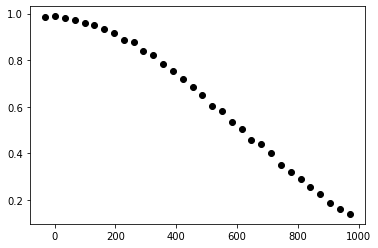

[0.00242805 0.08753486 0.48039631 0.50734138]


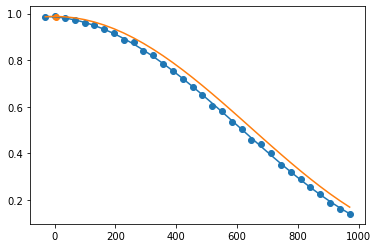

In [12]:
result = job.result()
print(result.get_counts())

x_values = widths
y_values = plot_counts(result, ['00', '01'], x=x_values)

init_params = [np.pi / 900., 0., 0.5, 0.5]
fitparams, conv = scipy.optimize.curve_fit(lambda width, v, phi0, amp, offset: offset + amp * np.cos(width * v + phi0), x_values, y_values, init_params)

print(fitparams)

plt.scatter(x_values, y_values)
plt.plot(x_values, fitparams[3] + fitparams[2] * np.cos(fitparams[0] * x_values + fitparams[1]))
plt.plot(x_values, fitparams[3] + fitparams[2] * np.cos(fitparams[0] * x_values))
plt.scatter([(0.1 - fitparams[1]) / fitparams[0]], [fitparams[3] + fitparams[2] * np.cos(0.1)])
plt.show()

### Discrepancy between the targeted $\phi$ from the initial calibration and the realized $\phi$

Negligible at large $\phi$, but inevitably large for small $\phi$ which is where the direct $R_{xz}$ is supposed to be useful the most.

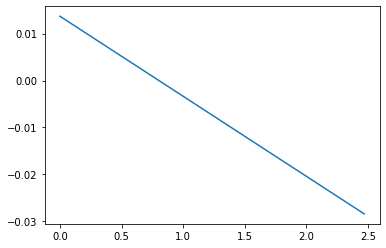

In [13]:
target_phi = widths * v + phi0
realized_phi = widths * fitparams[0] + fitparams[1]
plt.plot(target_phi, (realized_phi - target_phi))

## Error accumulation experiment

In [14]:
w01 = (0.1 - fitparams[1]) / fitparams[0]

rzx_circuit = linearized_rzx(w01, cx_schedule, phi_at_cx_width, backend)

circuits = []

for nrep in range(1, 11):
    circuit = QuantumCircuit(rzx_circuit.qregs[0])
    for _ in range(nrep):
        circuit.compose(rzx_circuit, inplace=True)
    circuit.measure_all()
    circuits.append(circuit)
    
for phi_value in np.linspace(0.1, 1., 10):
    width = (phi_value - fitparams[1]) / fitparams[0]
    circuit = linearized_rzx(width, cx_schedule, phi_at_cx_width, backend)
    circuit.measure_all()
    circuits.append(circuit)
    
circuits = transpile(circuits, backend=backend, initial_layout=[control_qubit, target_qubit])

#job = backend.run(circuits, shots=8192)
#print(job.job_id())

#job_monitor(job)

job = backend.retrieve_job('615c6ac9da98d5493d2b9491')

In [15]:
result = job.result()

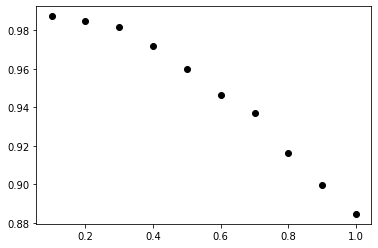

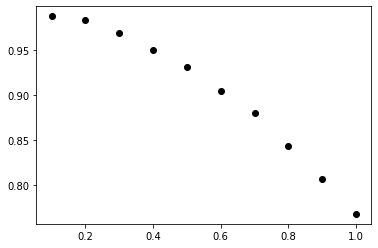

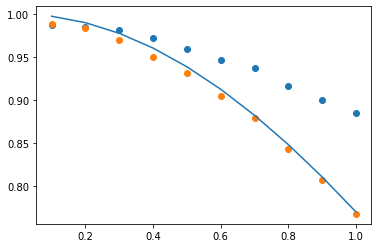

In [16]:
x_values = np.linspace(0.1, 1., 10)
y_incr = plot_counts(result, ['00', '01'], x=x_values, indices=np.arange(10))
y_direct = plot_counts(result, ['00', '01'], x=x_values, indices=np.arange(10, 20))
plt.scatter(x_values, y_incr)
plt.scatter(x_values, y_direct)
plt.plot(x_values, 0.5 * np.cos(x_values) + 0.5)

Error accumulates quite significantly

## Error accumulation with pulse-efficient scheme

In [17]:
rzx_circuit = pulse_efficient_rzx(0.1, cx_schedule, backend)

circuits = []

for nrep in range(1, 11):
    circuit = QuantumCircuit(rzx_circuit.qregs[0])
    for _ in range(nrep):
        circuit.compose(rzx_circuit, inplace=True)
    circuit.measure_all()
    circuits.append(circuit)
    
for phi_value in np.linspace(0.1, 1., 10):
    circuit = pulse_efficient_rzx(phi_value, cx_schedule, backend)
    circuit.measure_all()
    circuits.append(circuit)
    
circuits = transpile(circuits, backend=backend, initial_layout=[control_qubit, target_qubit])

#job = backend.run(circuits, shots=8192)
#print(job.job_id())

#job_monitor(job)

job = backend.retrieve_job('615c6b0e8fd55f06b9fac621')

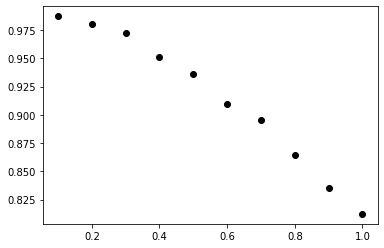

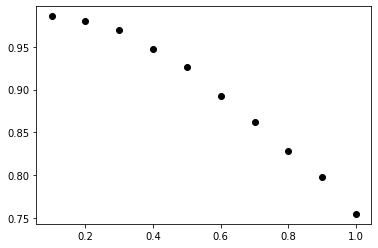

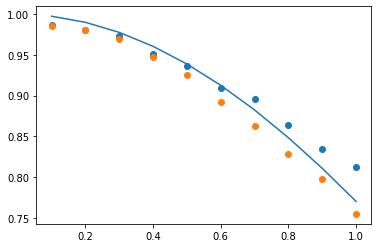

In [18]:
result = job.result()

x_values = np.linspace(0.1, 1., 10)
y_incr = plot_counts(result, ['00', '01'], x=x_values, indices=np.arange(10))
y_direct = plot_counts(result, ['00', '01'], x=x_values, indices=np.arange(10, 20))
plt.scatter(x_values, y_incr)
plt.scatter(x_values, y_direct)
plt.plot(x_values, 0.5 * np.cos(x_values) + 0.5)

## Error accumulation with CNOT

In [19]:
circuits = []

for nrep in range(1, 11):
    circuit = QuantumCircuit(2)
    for _ in range(nrep):
        circuit.rzx(0.1, 0, 1)
        circuit.barrier()
    circuit.measure_all()
    circuits.append(circuit)
    
circuits = transpile(circuits, backend=backend, initial_layout=[control_qubit, target_qubit])

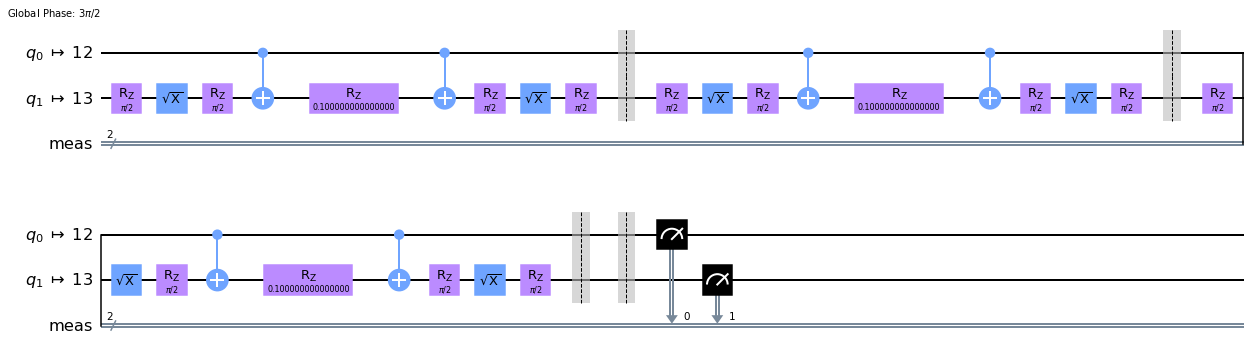

In [24]:
circuits[2].draw('mpl', idle_wires=False)

In [21]:
#job = backend.run(circuits, shots=8192)
#print(job.job_id())

#job_monitor(job)

In [22]:
job = backend.retrieve_job('615c081520df541a775e42a7')

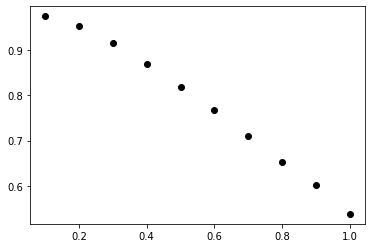

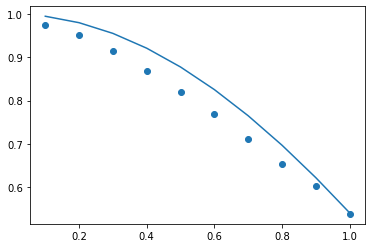

In [23]:
result = job.result()

x_values = np.linspace(0.1, 1., 10)
y_values = plot_counts(result, ['00', '01'], x=x_values)
plt.scatter(x_values, y_values)
plt.plot(x_values, np.cos(x_values))